In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


# Load the Dataset

In [2]:
videoDF = pd.read_csv('input/youtube_faces_with_keypoints_full.csv')
videoDF.head()

,videoID,personName,imageHeight,imageWidth,videoDuration,averageFaceSize,numVideosForPerson
0,Alison_Lohman_0,Alison_Lohman,228.0,213.0,240.0,90.150000,6.0
1,Alison_Lohman_1,Alison_Lohman,248.0,201.0,79.0,108.417722,6.0
2,Alison_Lohman_2,Alison_Lohman,335.0,308.0,136.0,122.161765,6.0
3,Alison_Lohman_3,Alison_Lohman,151.0,110.0,53.0,58.000000,6.0
4,Alison_Lohman_4,Alison_Lohman,236.0,228.0,147.0,91.680272,6.0


# **Exploratory Data Analysis**:

# Dataset Overview

In [3]:
print(f"Dataset shape: {videoDF.shape}")

Dataset shape: (2194, 7)


In [4]:
videoDF.describe()

,imageHeight,imageWidth,videoDuration,averageFaceSize,numVideosForPerson
count,2194.000000,2194.000000,2194.000000,2194.000000,2194.000000
mean,210.290337,195.633546,118.686873,94.887054,2.929809
std,64.514279,67.464967,71.806225,36.811662,0.959554
min,81.000000,74.000000,42.000000,40.220339,2.000000
25%,163.000000,147.000000,59.000000,67.337232,2.000000
50%,203.000000,185.000000,88.000000,87.578507,3.000000
75%,245.000000,234.000000,178.000000,114.550184,4.000000
max,480.000000,494.000000,240.000000,247.862745,6.000000


In [5]:
# There are no NaNs
videoDF.isna().sum()

videoID               0
personName            0
imageHeight           0
imageWidth            0
videoDuration         0
averageFaceSize       0
numVideosForPerson    0
dtype: int64

In [6]:
#Count the number of still images
print(f"Total number of frames/images: {videoDF['videoDuration'].sum():.0f}")

Total number of frames/images: 260399


In [7]:
print(f"Number of Videos: {videoDF.shape[0]}")

namelist = videoDF['personName'].unique()
print(f"Number of Unique Individuals: {len(namelist)}")

Number of Videos: 2194
Number of Unique Individuals: 828


In [8]:
# Number of videos per each person in dataset
videoDF.groupby(['personName'])['videoID'].count().sort_values(ascending=False)

personName
Kevin_Spacey           6
Alison_Lohman          6
Robert_F_Kennedy_Jr    6
Lauren_Hutton          6
Kim_Gandy              5
                      ..
Ham_Pong-sil           2
Zoran_Djindjic         2
Alberto_Acosta         1
Hana_Sadiq             1
Nobuyuki_Idei          1
Name: videoID, Length: 828, dtype: int64

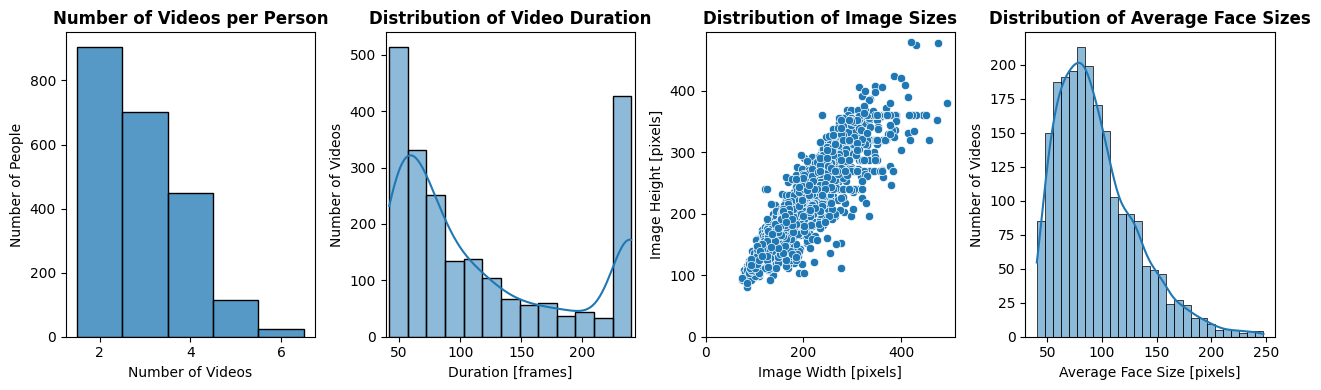

In [9]:
_, axes = plt.subplots(1, 4, figsize=(13,4))

sns.histplot(videoDF['numVideosForPerson'], bins=0.5+np.arange(videoDF['numVideosForPerson'].min()-1, videoDF['numVideosForPerson'].max()+1), ax=axes[0])
axes[0].set_title('Number of Videos per Person', fontweight='bold')
axes[0].set_xlabel('Number of Videos')
axes[0].set_ylabel('Number of People')

sns.histplot(videoDF['videoDuration'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Video Duration', fontweight='bold')
axes[1].set_xlabel('Duration [frames]')
axes[1].set_ylabel('Number of Videos')
axes[1].set_xlim(videoDF['videoDuration'].min()-3, videoDF['videoDuration'].max()+3)

sns.scatterplot(x='imageWidth', y='imageHeight', data=videoDF, ax=axes[2])
axes[2].set_title('Distribution of Image Sizes', fontweight='bold')
axes[2].set_xlabel('Image Width [pixels]')
axes[2].set_ylabel('Image Height [pixels]')
axes[2].set_xlim(0, videoDF['imageWidth'].max()+15)
axes[2].set_ylim(0, videoDF['imageHeight'].max()+15)

sns.histplot(videoDF['averageFaceSize'], kde=True, bins=28, ax=axes[3])
axes[3].set_title('Distribution of Average Face Sizes', fontweight='bold')
axes[3].set_xlabel('Average Face Size [pixels]')
axes[3].set_ylabel('Number of Videos')

plt.tight_layout()
plt.show()

# Locate the Video Files for Use

#### Glob is an extension of Python that assigns a filepath to each file in a given directory so that it can be called by the program.

In [10]:
# create array with all full file paths
npzFilesFullPath = glob.glob('input/youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/*.npz')

npzFilesFullPath=np.append(npzFilesFullPath,glob.glob('input/youtube_faces_with_keypoints_full_2/youtube_faces_with_keypoints_full_2/*.npz'))
npzFilesFullPath=np.append(npzFilesFullPath,glob.glob('input/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/*.npz'))
npzFilesFullPath=np.append(npzFilesFullPath,glob.glob('input/youtube_faces_with_keypoints_full_4/youtube_faces_with_keypoints_full_4/*.npz'))

npzFilesFullPath = [path.replace('\\', '/') for path in npzFilesFullPath]

print("Example of path:")
print(npzFilesFullPath[0])

# remove the .npz file extension
videoIDs = [x.split('/')[-1].split('.')[0] for x in npzFilesFullPath]
# create a dictionary that maps videoIDs to full file paths, key is the file name in dataframe (videoID), value is the filepath
fullPaths = {}
for videoID, fullPath in zip(videoIDs, npzFilesFullPath):
    fullPaths[videoID] = fullPath

Example of path:
input/youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Aaron_Eckhart_0.npz


# Display some Images from the videos with 2D Keypoints overlaid

In [11]:
# show several frames from each video and overlay 2D keypoints
np.random.seed(23)
numVideos = 4
framesToShowFromVideo = np.array([0.1, 0.5, 0.9])
numFramesPerVideo = len(framesToShowFromVideo)

# select a random subset of 'numVideos' from the available videos
randVideoIDs = videoDF.loc[np.random.choice(videoDF.index, size=numVideos, replace=False), 'videoID']
print(randVideoIDs)

64        Maria_Bello_1
1457      Cheryl_Ford_4
1736    James_Wattana_3
345        JK_Rowling_3
Name: videoID, dtype: object


In [12]:
# define which points need to be connected with a line
jawPoints          = [0,17]
rigthEyebrowPoints = [17,22]
leftEyebrowPoints  = [22,27]
noseRidgePoints    = [27,31]
noseBasePoints     = [31,36]
rightEyePoints     = [36,42]
leftEyePoints      = [42,48]
outerMouthPoints   = [48,60]
innerMouthPoints   = [60,68]

listOfAllConnectedPoints = [jawPoints,rigthEyebrowPoints,leftEyebrowPoints,
                            noseRidgePoints,noseBasePoints,
                            rightEyePoints,leftEyePoints,outerMouthPoints,innerMouthPoints]

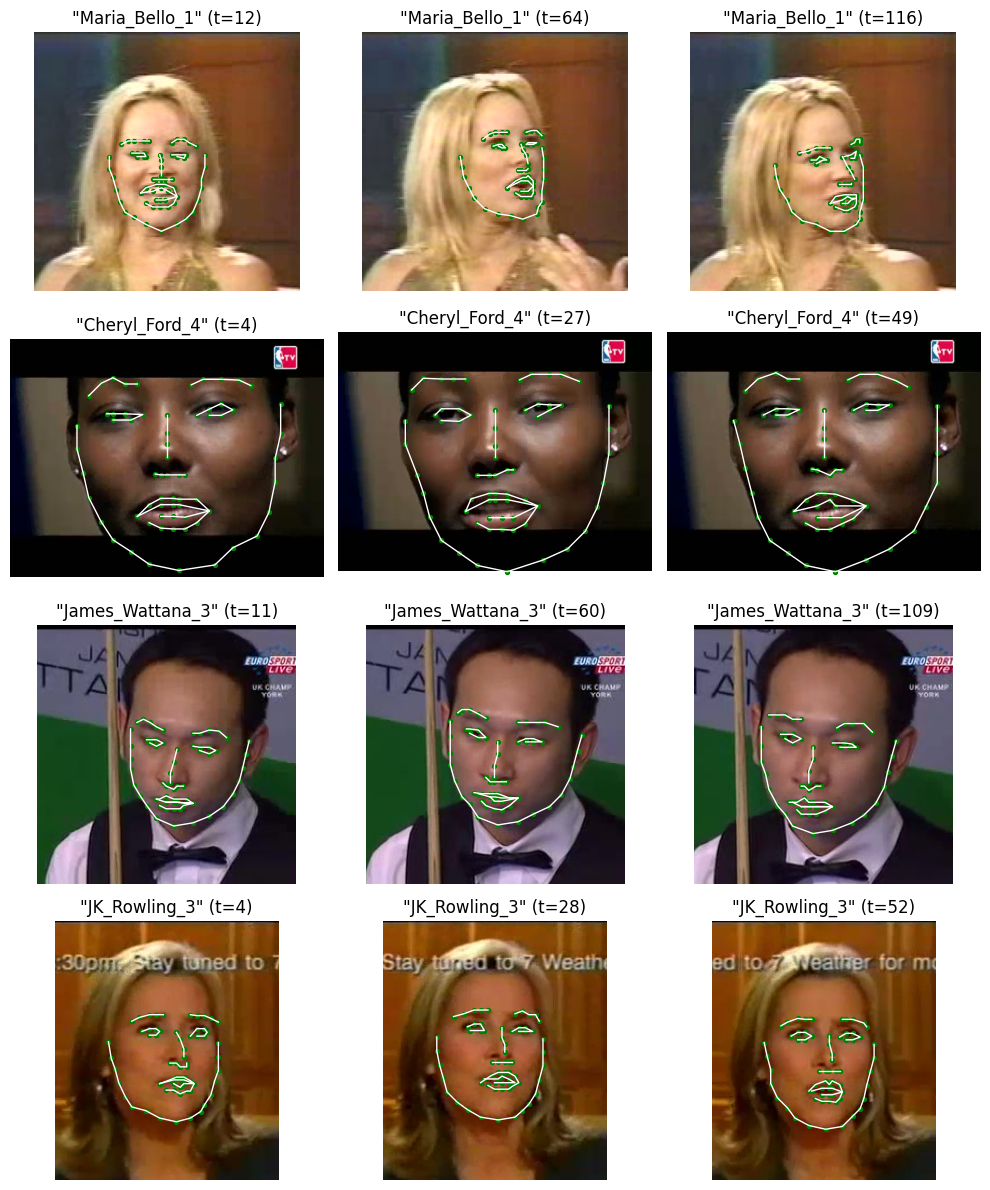

In [13]:
fig, axes = plt.subplots(nrows=numVideos, ncols=numFramesPerVideo, figsize=(10,12))

for i, videoID in enumerate(randVideoIDs):
    # load video
    videoFile = np.load(fullPaths[videoID])
    colorImages = videoFile['colorImages'] # arrays of the image colour values
    landmarks2D = videoFile['landmarks2D']

    # select frames and show their content with the landmark points
    selectedFrames = (framesToShowFromVideo * colorImages.shape[3]-1).astype(int)
    for j, frameInd in enumerate(selectedFrames):
        axes[i,j].imshow(colorImages[:,:,:,frameInd])
        axes[i,j].scatter(x=landmarks2D[:,0,frameInd], y=landmarks2D[:,1,frameInd], s=8, c='g')
        
        for conPts in listOfAllConnectedPoints:
            xPts = landmarks2D[conPts[0]:conPts[-1], 0, frameInd]
            yPts = landmarks2D[conPts[0]:conPts[-1], 1, frameInd]
            axes[i,j].plot(xPts, yPts, c='w', lw=1)

        axes[i,j].set_title(f'"{videoID}" (t={frameInd})')
        axes[i,j].set_axis_off()

plt.tight_layout()        
plt.show()